# DBPedia Topic Classification Dataset

Obtained from http://goo.gl/JyCnZq via [github](https://github.com/zhangxiangxiao/Crepe)
```
@misc{zhang2015characterlevel,
    title={Character-level Convolutional Networks for Text Classification},
    author={Xiang Zhang and Junbo Zhao and Yann LeCun},
    year={2015},
    eprint={1509.01626},
    archivePrefix={arXiv},
    primaryClass={cs.LG}
}
```

In [1]:
import pandas as pd
import os
from tqdm import tqdm
import hashlib

TRAIN_DATASET_LOCATION = "../datasets/dbpedia/train.csv"
TEST_DATASET_LOCATION = "../datasets/dbpedia/test.csv"

### Validity check

In [2]:
VERIFY_CHECKSUM = True

In [3]:
assert os.path.exists(TRAIN_DATASET_LOCATION)
assert os.path.exists(TEST_DATASET_LOCATION)

def verify_checksum(file, checksum):
    with open(file, "rb") as f:
        file_hash = hashlib.md5()
        while chunk := f.read(8192):
            file_hash.update(chunk)
    assert checksum == file_hash.hexdigest()
    print("Checksum matches")
    
if VERIFY_CHECKSUM:
    verify_checksum(TRAIN_DATASET_LOCATION, '9d6e9d329cd387303ccf24dd9a3d480a')
    verify_checksum(TEST_DATASET_LOCATION, '7d92b1d7727fb9d891d7888d46dee63c')

Checksum matches
Checksum matches


### Read data

##### For the analysis only `text` and `stars` will be used

In [4]:
def read_dbpedia(file, nrows=None):
    labels = ['Company', 'EducationalInstitution', 'Artist', 'Athlete', 'OfficeHolder', 'MeanOfTransportation', 'Building', 'NaturalPlace', 'Village', 'Animal', 'Plant', 'Album', 'Film', 'WrittenWork']
    df = pd.read_csv(file, nrows=nrows, header=None)
    df.columns = ['target', 'title', 'text']
    df.text = df.title.str.cat(df.text, sep=' - ')
    df.target = df.target.apply(lambda cl_idx: labels[cl_idx-1])
    df = df.drop(['title'], axis=1)
    return df

read_dbpedia(TRAIN_DATASET_LOCATION, nrows=10)

,target,text
0,Company,E. D. Abbott Ltd - Abbott of Farnham E D Abbo...
1,Company,Schwan-Stabilo - Schwan-STABILO is a German m...
2,Company,Q-workshop - Q-workshop is a Polish company l...
3,Company,Marvell Software Solutions Israel - Marvell S...
4,Company,Bergan Mercy Medical Center - Bergan Mercy Me...
5,Company,The Unsigned Guide - The Unsigned Guide is an...
6,Company,Rest of the world - Within sports and games p...
7,Company,Globoforce - Globoforce is a multinational co...
8,Company,Rompetrol - The Rompetrol Group N.V. is a Rom...
9,Company,Wave Accounting - Wave is the brand name for ...


In [5]:
df_train = read_dbpedia(TRAIN_DATASET_LOCATION)
df_train.shape

(560000, 2)

In [6]:
df_train.head()

,target,text
0,Company,E. D. Abbott Ltd - Abbott of Farnham E D Abbo...
1,Company,Schwan-Stabilo - Schwan-STABILO is a German m...
2,Company,Q-workshop - Q-workshop is a Polish company l...
3,Company,Marvell Software Solutions Israel - Marvell S...
4,Company,Bergan Mercy Medical Center - Bergan Mercy Me...


Text(0.5, 0, 'Count')

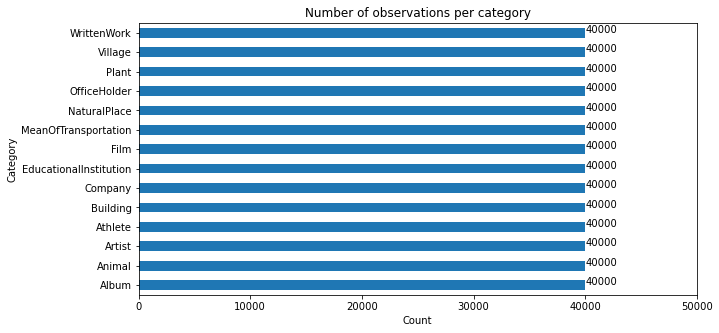

In [7]:
vc = df_train.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [8]:
PREPROCESSED_FILE = '../datasets/preprocessed/dbpedia_train.csv'
df_train.to_csv(PREPROCESSED_FILE, index=False)

### Detect Non-English texts

In [9]:
import fasttext
import numpy as np
from tqdm.notebook import tqdm_notebook

tqdm_notebook.pandas()

LANGUAGE_DETECTION_MODEL = "../fasttext/language_identification/lid.176.bin" #https://fasttext.cc/docs/en/language-identification.html
model = fasttext.load_model(LANGUAGE_DETECTION_MODEL)

In [10]:
def get_language(paragraph, k=None, return_all=False, min_certainty=0.25):
    if pd.isna(paragraph):
        return np.nan
    sentences = [line for line in paragraph.split("\n") if line != '']
    if len(sentences) < 1:
        return np.nan
    class_labels, certainties = model.predict(sentences, k)
    # sum certainties per class label and then divide by length -> avg certainty
    class_lookup, indexed_lang = np.unique(np.hstack(class_labels), return_inverse=True)
    summed_certainties = np.bincount(indexed_lang, weights=np.hstack(certainties))/len(sentences)
    if return_all:
        return dict(zip(class_lookup, summed_certainties))
    
    # get most likely lang
    lang_id = np.argmax(summed_certainties)
    if summed_certainties[lang_id] < min_certainty:
        return np.nan
    return class_lookup[lang_id]        

In [11]:
df_train['lang'] = df_train.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/560000 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

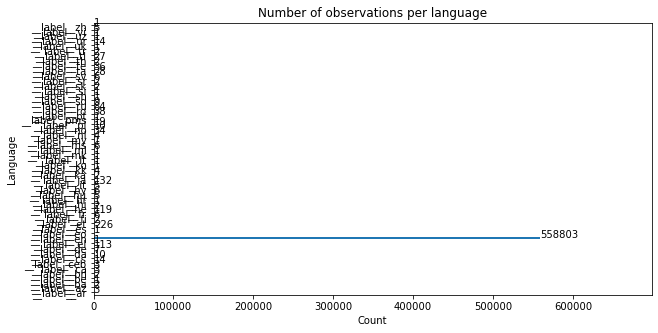

In [12]:
vc = df_train.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [13]:
vc.nlargest(5)

__label__en    558803
__label__es       226
__label__it       132
__label__fr       119
__label__de       113
Name: lang, dtype: int64

In [14]:
f"{vc['__label__en']/df_train.shape[0]*100:.4f}% of samples are english" 

'99.7862% of samples are english'

### Test Set analysis

In [15]:
df_test = read_dbpedia(TEST_DATASET_LOCATION)
df_test.shape

(70000, 2)

In [16]:
df_test.head()

,target,text
0,Company,TY KU - TY KU /taɪkuː/ is an American alcohol...
1,Company,Odd Lot Entertainment - OddLot Entertainment ...
2,Company,Henkel - Henkel AG & Company KGaA operates wo...
3,Company,GOAT Store - The GOAT Store (Games Of All Typ...
4,Company,RagWing Aircraft Designs - RagWing Aircraft D...


Text(0.5, 0, 'Count')

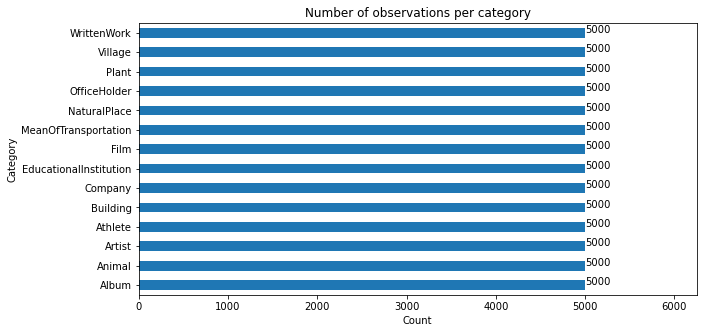

In [17]:
vc = df_test.target.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per category', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Category')
ax.set_xlabel('Count')

### Export file

In [18]:
PREPROCESSED_FILE = '../datasets/preprocessed/dbpedia_test.csv'
df_test.to_csv(PREPROCESSED_FILE, index=False)

In [19]:
df_test['lang'] = df_test.text.progress_apply(lambda review: get_language(review, k=5))

  0%|          | 0/70000 [00:00<?, ?it/s]

Text(0.5, 0, 'Count')

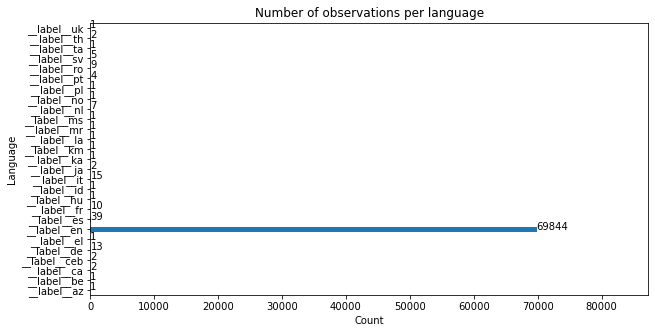

In [20]:
vc = df_test.lang.value_counts().sort_index()
ax = vc.plot(kind='barh', title='Number of observations per language', figsize=(10,5))
[ax.text(v, i, v) for i, v in enumerate(vc)]
ax.set_xlim(0, vc.max()*1.25)
ax.set_ylabel('Language')
ax.set_xlabel('Count')

In [21]:
vc.nlargest(5)

__label__en    69844
__label__es       39
__label__it       15
__label__de       13
__label__fr       10
Name: lang, dtype: int64

In [22]:
f"{vc['__label__en']/df_test.shape[0]*100:.4f}% of samples are english" 

'99.7771% of samples are english'